In [1]:
from davitpy import pydarn
import datetime
import numpy
import pandas
import altair as alt
alt.renderers.enable('notebook')
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
startTime = datetime.datetime(2017,12,2,2)
endTime = datetime.datetime(2017,12,2,5)
radSel = 'bks'
fileType = 'fitacf3'
filtered = False

In [3]:
f = pydarn.sdio.radDataOpen(startTime, radSel,
                    endTime, filtered=filtered,
                    fileType=fileType)

In [4]:
mb = pydarn.sdio.radDataReadAll(f)

In [5]:
stest1 = time.time()
x = []
# we'll create a dataframe with all the data
# To keep things simple (at this moment), I'm
# not using multi-indexed dataframe.
# Initialize empty arrays for the data
# these will later be converted to a DF
qflgArr = numpy.empty([0])
gateArr = numpy.empty([0])
velArr = numpy.empty([0])
spwArr = numpy.empty([0])
pwrArr = numpy.empty([0])
gflgArr = numpy.empty([0])
dtArr = numpy.empty([0])
bmArr = numpy.empty([0])
for n, m in enumerate(mb):
#     print numpy.array(m.fit.qflg )
    if m is None:
        continue
    if m.fit is None:
        continue
    if m.fit.v is None:
        continue
    qflgArr = numpy.concatenate( ( qflgArr, numpy.array(m.fit.qflg ) ) )
    gateArr = numpy.concatenate( ( gateArr, numpy.array(m.fit.slist ) ) )
    velArr = numpy.concatenate( ( velArr, numpy.array(m.fit.v ) ) )
    spwArr = numpy.concatenate( ( spwArr, numpy.array(m.fit.w_l ) ) )
    pwrArr = numpy.concatenate( ( pwrArr, numpy.array(m.fit.p_l ) ) )
    gflgArr = numpy.concatenate( ( gflgArr, numpy.array(m.fit.gflg ) ) )
    # date and bmnum are a little different
    dtArr = numpy.concatenate( ( dtArr, numpy.full( (len(m.fit.qflg)), m.time) ) )
    bmArr = numpy.concatenate( ( bmArr, numpy.full( (len(m.fit.qflg)), m.bmnum) ) )
dfx = pandas.DataFrame( {
    "qflg" : qflgArr,
    "gate" : gateArr,
    "vel" : velArr,
    "spw" : spwArr,
    "pwr" : pwrArr,
    "gflg" : gflgArr,
    "time" : dtArr,
    "beam" : bmArr,
})
# Convert int cols to int16
# they are being stored as 
# floats now! save space!
print "time cons1--->", time.time()-stest1
intCols = [ "qflg", "gate", "gflg", "beam" ]
dfx[intCols] = dfx[intCols].astype(numpy.int16)

time cons1---> 0.295554876328


In [6]:
dfx.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27168 entries, 0 to 27167
Data columns (total 8 columns):
beam    27168 non-null int16
gate    27168 non-null int16
gflg    27168 non-null int16
pwr     27168 non-null float64
qflg    27168 non-null int16
spw     27168 non-null float64
time    27168 non-null datetime64[ns]
vel     27168 non-null float64
dtypes: datetime64[ns](1), float64(3), int16(4)
memory usage: 1.0 MB


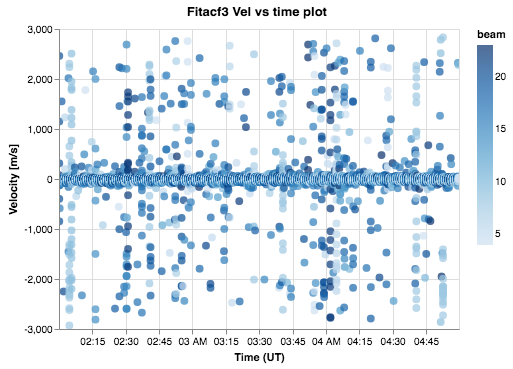

In [7]:
alt.data_transformers.enable('json')
alt.Chart(dfx).mark_circle(size=60).encode(
    x=alt.X('time', axis=alt.Axis(title='Time (UT)')),
    y=alt.Y('vel', axis=alt.Axis(title='Velocity [m/s]')),
    color='beam',
    tooltip=['vel', 'spw', 'pwr']
).properties(
    title='Fitacf3 Vel vs time plot'
).interactive()#.save("/tmp/test2.json")

In [8]:
# alt.Chart(dfx).mark_bar().encode(
#     alt.X("vel:Q", bin=True),
#     y='count()',
# ).save("test.html")

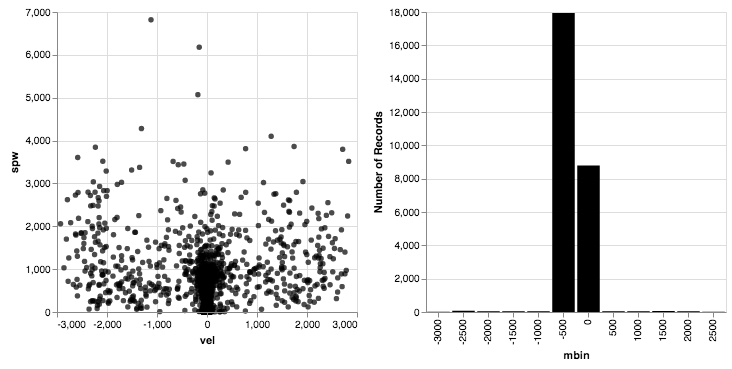

In [12]:
# interval selection in the scatter plot
pts = alt.selection(type="interval", encodings=["x"])

# left panel: scatter plot
points = alt.Chart().mark_point(filled=True, color="black").encode(
    x='vel',
    y='spw'
).transform_filter(
    pts.ref()
).properties(
    width=300,
    height=300
)

# right panel: histogram
mag = alt.Chart().mark_bar().encode(
    x='mbin:N',
    y="count()",
    color=alt.condition(pts, alt.value("black"), alt.value("lightgray"))
).properties(
    selection=pts,
    width=300,
    height=300
)

# build the chart:
alt.hconcat(points, mag,
    data=dfx
).transform_bin(
    "mbin",
    field="vel",
    bin=alt.Bin(maxbins=20)
)